# Untitled Supermarked Project
## Queing Simulator

### Importing Libraries

In [120]:
# DataFrames
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
# Statistics
from scipy import stats 
# Array and Array Math
import numpy as np

### Homebrew Functions

In [121]:
# Random generates an Entry-Process
def entry_process(packages, variable, parameters):
    # Set up Collector for results
    results       = pd.DataFrame([])
    # Generates randomly how much time passes between Customers
    results["time"]  = variable(** parameters, size = packages)
    # Sum up to determine entry time of each customer
    results["entry"] = results.time.cumsum()
    # Return result
    return results["entry"]

In [122]:
# Random-generates the the service-process and the resulting exit-process
def service_process(entries, variable, parameters, n_stations):
    # Set up Stations
    stations = list(np.repeat(0,n_stations))
    # Set up Collectors for Results
    results_service = ([])
    results_station = ([])
    results_exit    = ([]) 
    # Cycle through Customers of the Entry-Process
    for idx in entries:
        # Index of next available Station
        free = stations.index(min(stations))    
        # Add Time when Customer is being serviced
        results_service.append(max(idx,stations[free]))    
        # Generate time when Customer is done
        done = float(max(idx,stations[free]) + variable(** parameters, size = 1))
        # Add Time when Customer is done
        results_exit.append(done)
        # Add used Station
        results_station.append(free)
        # Update Station
        stations[free] = done   
    # Return results
    return results_service, results_exit, results_station

In [123]:
# Simulate Queue
def makeq(n_customers,
          entry_variable,entry_variable_parameters,
          service_variable,service_variable_parameters,
          n_stations):
    # Set Up Collector for Results
    overview                              = pd.DataFrame([])
    # Random Generate Entrance of Customers
    overview["entry"]                     = entry_process(n_customers,
                                                          entry_variable,
                                                          entry_variable_parameters)
    # Random Generate Service/ Exit of Customers
    overview["service"], overview["exit"], overview["station"] = service_process(overview["entry"], 
                                                                                 service_variable, 
                                                                                 service_variable_parameters, 
                                                                                 n_stations)
    # Return resulting Dataframe
    return(overview)

### Test Runs

#### M/M/1 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [124]:
title                       = "M/M/1 - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0}
n_stations                  = 1

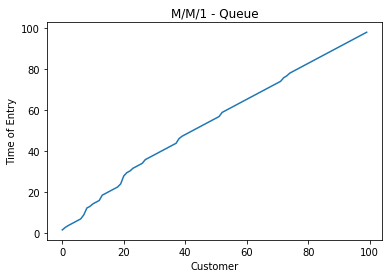

In [125]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                n_stations)
# Plot Results
plt.title(title)
plt.plot(example.exit)
plt.ylabel("Time of Entry")
plt.xlabel("Customer")
plt.show()

#### M/M/2 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [126]:
title                       = "M/M/2 - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0}
n_stations                  = 2

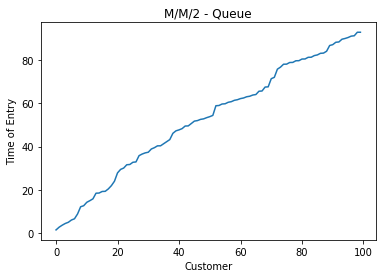

In [127]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                n_stations)
# Plot Results
plt.title(title)
plt.plot(example.exit)
plt.ylabel("Time of Entry")
plt.xlabel("Customer")
plt.show()

## Work in Progess

### Monte Carlo Studies 

In [ ]:
runs       = 100
resolution = 5

In [ ]:
sets = pd.DataFrame([])
for idx in range(1,runs+1):    
    sets = sets.append(makeq(n_customers,entry_variable,entry_variable_parameters,service_variable,service_variable_parameters).exit)

In [ ]:
results = pd.DataFrame([])
for idx in range(0,int(sets.max().max())+1,resolution):
    results[str(idx)] = (((sets >= 0 + idx)&(sets > idx + resolution)).sum(axis = 1))

In [ ]:
plt.boxplot(results.T)
plt.show()

In [ ]:
test     = makeq(n_customers,entry_variable,entry_variable_parameters,service_variable,service_variable_parameters).exit
results2 = pd.DataFrame([])
for idx in range(0,int(test.max().max())+1,resolution):
    results2[str(idx)] = ((test >= 0 + idx)&(test > idx + resolution))

## Future Works
- Multiple Stations, non Stationar via Shiftplan<br>
- Non Stationary Entry-Process<br>
- Non Stationary Service-Process<br>
- Consider List vs Numpy vs Pandas
- Consider Object-Oriented approach<br>